In [1]:
import json
import numpy as np
import cv2
from glob import glob
from os.path import join as pjoin
from tqdm import tqdm


def resize_label(bboxes, d_height, gt_height, bias=0):
    bboxes_new = []
    scale = gt_height / d_height
    for bbox in bboxes:
        bbox = [int(b * scale + bias) for b in bbox]
        bboxes_new.append(bbox)
    return bboxes_new


def draw_bounding_box(org, corners, color=(0, 255, 0), line=2, show=False):
    board = org.copy()
    for i in range(len(corners)):
        board = cv2.rectangle(board, (corners[i][0], corners[i][1]), (corners[i][2], corners[i][3]), color, line)
    if show:
        cv2.imshow('a', cv2.resize(board, (500, 1000)))
        cv2.waitKey(0)
    return board


def load_detect_result_json(reslut_file_root, shrink=0):
    def is_bottom_or_top(corner):
        column_min, row_min, column_max, row_max = corner
        if row_max < 36 or row_min > 725:
            return True
        return False

    result_files = glob(pjoin(reslut_file_root, '*.json'))
    compos_reform = {}
    print('Loading %d detection results' % len(result_files))
    for reslut_file in tqdm(result_files):
        img_name = reslut_file.split('\\')[-1].split('.')[0]
        compos = json.load(open(reslut_file, 'r'))['compos']
        for compo in compos:
            if is_bottom_or_top((compo['column_min'], compo['row_min'], compo['column_max'], compo['row_max'])):
                continue
            if img_name not in compos_reform:
                compos_reform[img_name] = {'bboxes': [[compo['column_min'] + shrink, compo['row_min'] + shrink, compo['column_max'] - shrink, compo['row_max'] - shrink]],
                                           'categories': [compo['category']]}
            else:
                compos_reform[img_name]['bboxes'].append([compo['column_min'] + shrink, compo['row_min'] + shrink, compo['column_max'] - shrink, compo['row_max'] - shrink])
                compos_reform[img_name]['categories'].append(compo['category'])
    return compos_reform


def load_ground_truth_json(gt_file):
    def get_img_by_id(img_id):
        for image in images:
            if image['id'] == img_id:
                return image['file_name'].split('/')[-1][:-4], (image['height'], image['width'])

    def cvt_bbox(bbox):
        '''
        :param bbox: [x,y,width,height]
        :return: [col_min, row_min, col_max, row_max]
        '''
        bbox = [int(b) for b in bbox]
        return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

    data = json.load(open(gt_file, 'r'))
    images = data['images']
    annots = data['annotations']
    compos = {}
    print('Loading %d ground truth' % len(annots))
    for annot in tqdm(annots):
        img_name, size = get_img_by_id(annot['image_id'])
        if img_name not in compos:
            compos[img_name] = {'bboxes': [cvt_bbox(annot['bbox'])], 'categories': [annot['category_id']], 'size': size}
        else:
            compos[img_name]['bboxes'].append(cvt_bbox(annot['bbox']))
            compos[img_name]['categories'].append(annot['category_id'])
    return compos


def eval(detection, ground_truth, img_root, show=True, no_text=False, only_text=False):
    def compo_filter(compos, flag):
        if not no_text and not only_text:
            return compos
        compos_new = {'bboxes': [], 'categories': []}
        for k, category in enumerate(compos['categories']):
            if only_text:
                if flag == 'det' and category != 'TextView':
                    continue
                if flag == 'gt' and int(category) != 14:
                    continue
            elif no_text:
                if flag == 'det' and category == 'TextView':
                    continue
                if flag == 'gt' and int(category) == 14:
                    continue

            compos_new['bboxes'].append(compos['bboxes'][k])
            compos_new['categories'].append(category)
        return compos_new

    def match(org, d_bbox, gt_bboxes, matched):
        '''
        :param matched: mark if the ground truth component is matched
        :param d_bbox: [col_min, row_min, col_max, row_max]
        :param gt_bboxes: list of ground truth [[col_min, row_min, col_max, row_max]]
        :return: Boolean: if IOU large enough or detected box is contained by ground truth
        '''
        area_d = (d_bbox[2] - d_bbox[0]) * (d_bbox[3] - d_bbox[1])
        for i, gt_bbox in enumerate(gt_bboxes):
            if matched[i] == 0:
                continue
            area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
            col_min = max(d_bbox[0], gt_bbox[0])
            row_min = max(d_bbox[1], gt_bbox[1])
            col_max = min(d_bbox[2], gt_bbox[2])
            row_max = min(d_bbox[3], gt_bbox[3])
            # if not intersected, area intersection should be 0
            w = max(0, col_max - col_min)
            h = max(0, row_max - row_min)
            area_inter = w * h
            if area_inter == 0:
                continue
            iod = area_inter / area_d
            iou = area_inter / (area_d + area_gt - area_inter)
            # if show:
            #     cv2.putText(org, (str(round(iou, 2)) + ',' + str(round(iod, 2))), (d_bbox[0], d_bbox[1]),
            #                 cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            if iou > 0.9 or iod == 1:
                matched[i] = 0
                return True
        return False

    amount = len(detection)
    TP, FP, FN = 0, 0, 0
    pres, recalls, f1s = [], [], []
    for i, image_id in enumerate(detection):
        TP_this, FP_this, FN_this = 0, 0, 0
        img = cv2.imread(pjoin(img_root, image_id + '.jpg'))
        d_compos = detection[image_id]
        gt_compos = ground_truth[image_id]

        org_height = gt_compos['size'][0]

        d_compos = compo_filter(d_compos, 'det')
        gt_compos = compo_filter(gt_compos, 'gt')

        d_compos['bboxes'] = resize_label(d_compos['bboxes'], 800, org_height)
        matched = np.ones(len(gt_compos['bboxes']), dtype=int)
        for d_bbox in d_compos['bboxes']:
            if match(img, d_bbox, gt_compos['bboxes'], matched):
                TP += 1
                TP_this += 1
            else:
                FP += 1
                FP_this += 1
        FN += sum(matched)
        FN_this = sum(matched)

        try:
            pre_this = TP_this / (TP_this + FP_this)
            recall_this = TP_this / (TP_this + FN_this)
            f1_this = 2 * (pre_this * recall_this) / (pre_this + recall_this)
        except:
            print('empty')
            continue

        pres.append(pre_this)
        recalls.append(recall_this)
        f1s.append(f1_this)
        if show:
            print(image_id + '.jpg')
            print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (
                i, amount, TP_this, FP_this, FN_this, pre_this, recall_this))
            cv2.imshow('org', cv2.resize(img, (500, 1000)))
            broad = draw_bounding_box(img, d_compos['bboxes'], color=(255, 0, 0), line=3)
            draw_bounding_box(broad, gt_compos['bboxes'], color=(0, 0, 255), show=True, line=2)

        if i % 200 == 0:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * (precision * recall) / (precision + recall)
            print(
                '[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f, F1:%.3f' % (i, amount, TP, FP, FN, precision, recall, f1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f, F1:%.3f' % (i, amount, TP, FP, FN, precision, recall, f1))
    # print("Average precision:%.4f; Average recall:%.3f" % (sum(pres)/len(pres), sum(recalls)/len(recalls)))

    return pres, recalls, f1s

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import math

def draw_plot(data, title='Score for our approach'):
    for i in range(len(data)):
        data[i] = [d for d in data[i] if not math.isnan(d)]
#     plt.title(title)
    labels = ['Precision', 'Recall', 'F1']
    bplot = plt.boxplot(data, patch_artist=True, labels=labels)  # 设置箱型图可填充
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color) 
    plt.grid(axis='y')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(title + '.png')
    plt.show()

In [9]:
detect = load_detect_result_json('E:\\Mulong\\Result\\rico\\rico_uied\\rico_new_uied_cls\\merge')

  9%|███████▏                                                                     | 442/4708 [00:00<00:01, 4173.66it/s]

Loading 4708 detection results


100%|████████████████████████████████████████████████████████████████████████████| 4708/4708 [00:01<00:00, 4404.67it/s]


In [10]:
gt = load_ground_truth_json('E:\\Mulong\\Datasets\\rico\\instances_test.json')

  8%|█████▉                                                                    | 6915/86646 [00:00<00:01, 68670.52it/s]

Loading 86646 ground truth


100%|██████████████████████████████████████████████████████████████████████████| 86646/86646 [00:11<00:00, 7576.11it/s]


In [23]:
no_text = False
only_text = False
pres_all, recalls_all, f1_all = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False, no_text=no_text, only_text=only_text)

[0/4707] TP:16, FP:0, FN:0, Precesion:1.000, Recall:1.000, F1:1.000


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


[200/4707] TP:2222, FP:2920, FN:1705, Precesion:0.432, Recall:0.566, F1:0.490
[400/4707] TP:4616, FP:5737, FN:3346, Precesion:0.446, Recall:0.580, F1:0.504
[600/4707] TP:6963, FP:8682, FN:4812, Precesion:0.445, Recall:0.591, F1:0.508
[800/4707] TP:9367, FP:11432, FN:6305, Precesion:0.450, Recall:0.598, F1:0.514
[1000/4707] TP:11222, FP:14346, FN:7511, Precesion:0.439, Recall:0.599, F1:0.507
[1200/4707] TP:13680, FP:17278, FN:8901, Precesion:0.442, Recall:0.606, F1:0.511
[1400/4707] TP:16274, FP:20664, FN:10379, Precesion:0.441, Recall:0.611, F1:0.512
[1600/4707] TP:18431, FP:23002, FN:11556, Precesion:0.445, Recall:0.615, F1:0.516
[1800/4707] TP:20718, FP:25600, FN:13049, Precesion:0.447, Recall:0.614, F1:0.517
[2000/4707] TP:23009, FP:28626, FN:14588, Precesion:0.446, Recall:0.612, F1:0.516
[2200/4707] TP:25424, FP:31555, FN:16191, Precesion:0.446, Recall:0.611, F1:0.516
[2400/4707] TP:27559, FP:34176, FN:17388, Precesion:0.446, Recall:0.613, F1:0.517
[2600/4707] TP:29820, FP:37065, F

In [21]:
no_text = True
only_text = False
pres_non_text, recalls_non_text, f1_non_text = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False, no_text=no_text, only_text=only_text)

[0/4707] TP:1, FP:0, FN:0, Precesion:1.000, Recall:1.000, F1:1.000


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


[200/4707] TP:973, FP:2022, FN:891, Precesion:0.325, Recall:0.522, F1:0.400
empty
[400/4707] TP:1921, FP:3905, FN:1788, Precesion:0.330, Recall:0.518, F1:0.403
[600/4707] TP:2847, FP:6079, FN:2717, Precesion:0.319, Recall:0.512, F1:0.393
empty
empty
empty
[800/4707] TP:3774, FP:7895, FN:3574, Precesion:0.323, Recall:0.514, F1:0.397
empty
[1000/4707] TP:4478, FP:9951, FN:4229, Precesion:0.310, Recall:0.514, F1:0.387
empty
empty
[1200/4707] TP:5451, FP:12055, FN:4960, Precesion:0.311, Recall:0.524, F1:0.391
empty
empty
empty
[1400/4707] TP:6493, FP:14405, FN:5804, Precesion:0.311, Recall:0.528, F1:0.391
empty
empty
empty
empty
[1600/4707] TP:7372, FP:15980, FN:6375, Precesion:0.316, Recall:0.536, F1:0.397
empty
empty
empty
[1800/4707] TP:8273, FP:17814, FN:7156, Precesion:0.317, Recall:0.536, F1:0.399
empty
empty
[2000/4707] TP:9273, FP:19993, FN:8051, Precesion:0.317, Recall:0.535, F1:0.398
empty
[2200/4707] TP:10293, FP:22055, FN:8869, Precesion:0.318, Recall:0.537, F1:0.400
[2400/4707

In [14]:
no_text = False
only_text = True
pres_text, recalls_text, f1_text = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False, no_text=no_text, only_text=only_text)

[0/4707] TP:15, FP:0, FN:0, Precesion:1.000, Recall:1.000, F1:1.000
empty


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
[200/4707] TP:1041, FP:1106, FN:1022, Precesion:0.485, Recall:0.505, F1:0.495
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
[400/4707] TP:2185, FP:2342, FN:2068, Precesion:0.483, Recall:0.514, F1:0.498
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
[600/4707] TP:3272, FP:3447, FN:2939, Precesion:0.487, Recall:0.527, F1:0.506
empty
empty
empty
empty
empty
empty
empty
[800/4707] TP:4505, FP:4625, FN:3819, Precesion:0.493, Recall:0.541, F1:0.516
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
[1000/4707] TP:5426, FP:5713, FN:4600, Precesion:0.487, Recall:0.541, F1:0.513
empty
empty
empty
empty
empty
empty
empty
[1200/4707] TP:6649, FP:6803, FN:5521, Precesion:0.494, Recall:0.546, F1:0.519
empty
empty
empty
empty
empty
empty
[1400/4707] TP:7890, FP:8150, FN:6466, Precesion:0.492, Recall:0.550, F1:0.519
empty
empty
empty
empty
e

D:\Anaconda\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


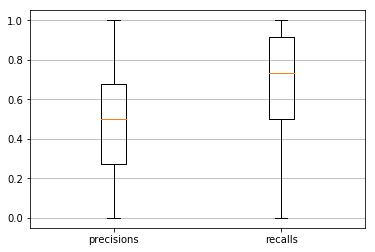

In [15]:
draw_plot([pres_all, recalls_all])

D:\Anaconda\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


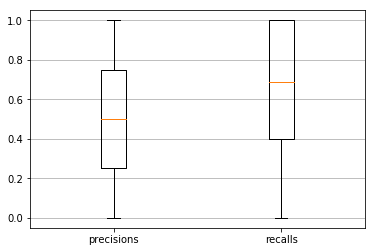

In [16]:
draw_plot([pres_non_text, recalls_non_text])

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pres1 = pd.DataFrame({'score_type':'Precision', 'score': pres_non_text, 'class':'Non_text'})
pres2 = pd.DataFrame({'score_type':'Precision', 'score': pres_all, 'class':'All_element'})

recalls1 = pd.DataFrame({'score_type':'Recall', 'score':recalls_non_text, 'class':'Non_text'})
recalls2 = pd.DataFrame({'score_type':'Recall', 'score':recalls_all, 'class':'All_element'})

f1s1 = pd.DataFrame({'score_type':'F1', 'score':f1_non_text, 'class':'Non_text'})
f1s2 = pd.DataFrame({'score_type':'F1', 'score':f1_all, 'class':'All_element'})

data=pd.concat([pres1, pres2, recalls1, recalls2, f1s1, f1s2])

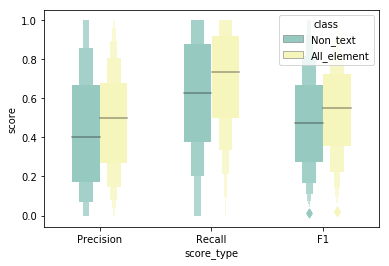

In [36]:
sns.boxenplot(x='score_type', y='score', hue='class', data=data, width=0.5, linewidth=1.0, palette="Set3")

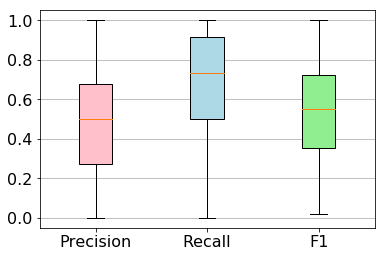

In [74]:
draw_plot([pres_all, recalls_all, f1_all], title='Scores for All Elements')

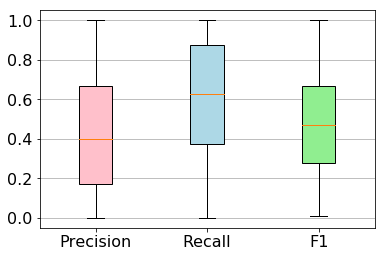

In [75]:
draw_plot([pres_non_text, recalls_non_text, f1_non_text], title='Score for Non-text Elements')